In [ ]:
!pip install xgboost zipcodes --user

In [79]:
%matplotlib inline
from joblib import dump, load
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import xgboost as xgb
import zipcodes

# Models
from sklearn.ensemble import BaggingRegressor as BR, RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score, ParameterGrid

from xgboost import XGBRegressor as XGBR, DMatrix

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Metrics
from sklearn.metrics import r2_score, mean_squared_error

DIVIDER='-'*100
TRAIN_SMALL_PATH = "./etc/training_small.csv"
TRAIN_LARGE_PATH = "./etc/training_large.csv"
TEST_PATH = "./etc/test.csv"
TARGET = "price"

HIGH_RELEVANCE_COLS = ['price', 'back_legroom', 'front_legroom', 'fuel_tank_volume',
                       'height', 'length', 'wheelbase', 'width', #'model_name',
                       'city_fuel_economy', 'highway_fuel_economy', 'engine_displacement',
                       'horsepower', 'year', 'mileage', 'make_name', 'body_type']

NUMERICAL_COLS_BEFORE_IMPUTATION = ['price', 'back_legroom', 'front_legroom', 'fuel_tank_volume',
                                    'height', 'length', 'wheelbase', 'width', 'city_fuel_economy',
                                    'highway_fuel_economy', 'engine_displacement', 'horsepower',
                                    'year', 'mileage']
NUMERICAL_COLS_AFTER_IMPUTATION = ['legroom', 'size_of_vehicle', 'mileage',
                                   'combined_fuel_economy', 'engine_vol_vs_hp','year']
CATEGORICAL_COLS = ['make_name', 'body_type'] #, 'model_name']

BAGGING_PARAMS = {
    'n_estimators': np.arange(10, 101, 10),  # Number of base estimators in the ensemble
    'max_samples': np.arange(0.1, 1.1, 0.1),  # The number of samples to draw from X to train each base estimator
    'max_features': np.arange(0.1, 1.1, 0.1),  # The number of features to draw from X to train each base estimator
    'bootstrap': [True, False],  # Whether samples are drawn with replacement
    'oob_score': [True, False],  # Whether to use out-of-bag samples to estimate the generalization error
}

RFR_PARAMS = {
    'n_estimators': np.arange(10, 101, 10),  # Number of trees in the forest
    'max_depth': np.arange(3, 17, 2).tolist() + [None],  # Maximum depth of the tree
    'min_samples_split': np.arange(2, 11, 2),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 11, 2),  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', 1.0],  # Number of features to consider when looking for the best split
}

XGBR_PARAMS = {
    'n_estimators': np.arange(10, 101, 10),  # Number of gradient boosted trees
    'learning_rate': [0.001, 0.01, 0.05, 0.1],  # Step size shrinkage to prevent overfitting
    'max_depth': np.arange(3, 11, 2),  # Maximum depth of a tree
    'gamma': [i/10.0 for i in range(0, 5)],  # Minimum loss reduction required to make a further partition
    'subsample': [i/10.0 for i in range(3, 11)],  # Fraction of samples used per tree
    'colsample_bytree': [i/10.0 for i in range(3, 11)],  # Fraction of features used per tree
    'reg_alpha': [1e-2, 0.1, 1, 100],  # L1 regularization term on weights
    'eval_metric': ['rmse'],
    'objective': ['reg:squarederror']
}

SVR_PARAMS = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'sigmoid'],  # Type of the kernel
    'degree': [1, 2, 3],  # Degree of the polynomial kernel function ('poly'). Ignored by all other kernels.
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'poly' and 'sigmoid'
    'epsilon': [0.1, 0.2, 0.5, 0.3],  # Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.
}

# Preprocessing

In [ ]:
# Helper functions and plotting
def label_encode(dataFrame, cols, testing=False, les=None):
    if not testing:
        les = {}
        for col in cols:
            le = LabelEncoder()
            dataFrame[col] = le.fit_transform(dataFrame[col])
            les[col] = le
    else:
        for col in cols:
            dataFrame[col] = les[col].transform(dataFrame[col])
    return les

def plot_residuals(actual_values, predicted_values, filename: str):
    residuals = actual_values - predicted_values
    
    skew = stats.skew(residuals)
    kurtosis = stats.kurtosis(residuals)
    print("Skew: ", skew)
    print("Kurtosis: ", kurtosis)
    
    # Set up the subplot layout
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Residuals Plot
    ax[0].scatter(predicted_values, residuals, alpha=0.6)
    ax[0].axhline(y=0, color='r', linestyle='--')
    ax[0].set_xlabel('Predicted Values')
    ax[0].set_ylabel('Residuals')
    ax[0].set_title('Residuals vs. Predicted Values')

    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title('Q-Q plot of the Residuals')

    plt.tight_layout()
    plt.savefig(f"./img/{filename}_residuals.png")
    plt.show()
    
    return skew, kurtosis

def plot_actual_vs_predicted(actual_values, predicted_values, filename: str, title: str ='Predicted vs Actual'):
    """
    Plot actual values against predicted values in a scatter plot.
    
    Parameters:
    - actual_values: Actual target values.
    - predicted_values: Predicted values from the model.
    - title: Title of the plot.
    
    Returns:
    - A scatter plot of actual vs. predicted values.
    """    
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.5)
    plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red')  # Diagonal line
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.savefig(f"./img/{filename}.png")
    plt.show()

def plot_price_vs_mileage(large: bool = False):
    d = "small"
    path = TRAIN_SMALL_PATH
    if large:
        d = "large"
        path = TRAIN_LARGE_PATH
    
    df = pd.read_csv(path)
    plt.figure(figsize=(8, 6))
    
    # Define the bin edges for grouping the mileage
    bin_edges = np.arange(1000, 125500, 500)

    # Use cut to bin the mileages, then group by bin and calculate the average price
    df['mileage_bin'] = pd.cut(df['mileage'], bins=bin_edges, include_lowest=True, right=False)
    bin_centers = bin_edges[:-1] + 250  # centers of bins for plotting
    avg_prices_per_bin = df.groupby('mileage_bin')['price'].mean()

    # Plot the average prices per bin
    plt.scatter(bin_centers, avg_prices_per_bin, color='deepskyblue')

    # Add vertical lines at each 10,000-mile mark
    for x in range(10000, 125000, 10000):
        plt.axvline(x=x, color='black', linestyle='-', linewidth=2)
    
    # Calculate and plot lines of best fit for every 10,000 units of mileage
    for start_mile in range(0, 120000, 10000):
        end_mile = start_mile + 10000
        # Filter the segment's data
        segment = df[(df['mileage'] >= start_mile) & (df['mileage'] < end_mile)]
        if not segment.empty:
            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(segment['mileage'], segment['price'])
            # Generate x values for the line of best fit: from start_mile to end_mile
            line_x = np.array([start_mile, end_mile])
            # Calculate the corresponding y values using the regression equation
            line_y = slope * line_x + intercept
            # Plot the line of best fit
            plt.plot(line_x, line_y, 'r')
    
    # Set plot titles and labels
    plt.title(f'Average Car Price vs. Mileage ({d} dataset)')
    plt.xlabel('Mileage')
    plt.ylabel('Average Sale Price')
    plt.grid(True)
    plt.savefig(f"./img/price_vs_mileage_{d}.png")
    plt.show()

In [ ]:
HIGH_RELEVANCE_COLS = ['price', 'back_legroom', 'front_legroom', 'fuel_tank_volume',
                       'height', 'length', 'wheelbase', 'width', #'model_name',
                       'city_fuel_economy', 'highway_fuel_economy', 'engine_displacement',
                       'horsepower', 'year', 'mileage', 'make_name', 'body_type']

NUMERICAL_COLS_BEFORE_IMPUTATION = ['price', 'back_legroom', 'front_legroom', 'fuel_tank_volume',
                                    'height', 'length', 'wheelbase', 'width', 'city_fuel_economy',
                                    'highway_fuel_economy', 'engine_displacement', 'horsepower',
                                    'year', 'mileage']
NUMERICAL_COLS_AFTER_IMPUTATION = ['legroom', 'size_of_vehicle', 'mileage',
                                   'combined_fuel_economy', 'engine_vol_vs_hp','year']
CATEGORICAL_COLS = ['make_name', 'body_type'] #, 'model_name']

def preprocess(df: pd.DataFrame, testing: bool = False, les = None):
    # Create a copy of the DataFrame
    X = df.copy()
    
    # Remove entries less than $40,000
    X = X[X["price"] > 40000]

    # Select only a few columns
    X = X[HIGH_RELEVANCE_COLS]
    
    # print("After filtering: \n", X.columns)
    
    if (testing):
        y = None
    else:
        # Get the target
        y = X["price"].apply(lambda x: math.log(x))
        X.drop("price", axis=1, inplace=True)
    
    # Feature engineering, part 1
    # Select only top 20 makes
    top_20_make = X['make_name'].value_counts()[:20].index
    def is_top_20_make(make):
        return make if make in top_20_make else 'Other'
    X['make_name'] = X['make_name'].apply(is_top_20_make)

#     top_20_model = X['model_name'].value_counts()[:20].index
#     def is_top_20_model(model):
#         return model if model in top_20_model else 'Other'
#     X['model_name'] = X['model_name'].apply(is_top_20_model)
#     print(X['model_name'].value_counts())
    
    
    def process_column(data: pd.DataFrame, column, dtype='float') -> pd.DataFrame:
        data[column] = data[column].str.split(' ').str[0].replace('--', np.nan).astype(dtype)
        return data

    # Process columns
    for col in ['back_legroom', 'front_legroom', 'fuel_tank_volume', 
                'height', 'length', 'wheelbase', 'width']:
        X = process_column(X, col)

    X = pd.DataFrame(X)
    
    # print("After processing: \n", X.columns)
    
    # Use different transformers for numerical and categorical columns
    numerical_transformer = Pipeline([
        ('scaler', MinMaxScaler()),
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ])
    
    les = label_encode(X, CATEGORICAL_COLS)

    # Define a simplified ColumnTransformer with a single transformer
    # The steps of this pipeline are as follows:
    # 1. Scaling: Scales values according to the N(0, 1) distribution
    # 2. Impute: Deals with NaNs by imputing them with the mean
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, NUMERICAL_COLS_BEFORE_IMPUTATION[1:]), # Don't include "price"
            ('cat', categorical_transformer, CATEGORICAL_COLS)
        ])

    # Create a pipeline
    pipe = Pipeline([('preprocessor', preprocessor)])
    
    # print("Before fitting pipeline: \n", sorted(X.columns))
    # print('-'*100)
    # print("Expected cols: ", sorted(set(CATEGORICAL_COLS + NUMERICAL_COLS_BEFORE_IMPUTATION[1:])))
    
    # Sanity check
    assert set(X.columns) == set(CATEGORICAL_COLS + NUMERICAL_COLS_BEFORE_IMPUTATION[1:])
    
    X = pd.DataFrame(pipe.fit_transform(X), columns=X.columns)
    
    # Feature engineering part 2
    X['combined_fuel_economy'] = (X['city_fuel_economy'] + X['highway_fuel_economy']) / 2    
    X['engine_vol_vs_hp'] = X['engine_displacement'] / X['horsepower']
    X['size_of_vehicle'] = X[['length', 'width', 'height', 'wheelbase', 'fuel_tank_volume']].sum(axis=1)
    X['legroom'] = X['front_legroom'] + X['back_legroom']

    # Deal with infinities
    X['engine_vol_vs_hp'].replace([np.inf, -np.inf], 0, inplace=True)

    # Drop columns
    X.drop(['city_fuel_economy', 'highway_fuel_economy', 'engine_displacement',
            'horsepower', 'length', 'width', 'height', 'fuel_tank_volume',
            'wheelbase', 'front_legroom', 'back_legroom'], axis=1, inplace=True)

    if (not testing):
        # Convert the labels to integers
        for col in CATEGORICAL_COLS:
                X[col] = X[col].apply(lambda x: int(x))
                
    # Sanity check
    assert set(X.columns) == set(CATEGORICAL_COLS + NUMERICAL_COLS_AFTER_IMPUTATION)

    return X, y, les

def train_and_evaluate(model, X_train, y_train, X_test, y_test, params: dict):    
    # Use GridSearchCV with the maximum number of CPU cores available
    grid_search = GridSearchCV(model, params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)

    print("Starting grid search: ", grid_search)
    
    # Train the model using GridSearchCV
    grid_search.fit(X_train, y_train)
    
    print("Grid search complete.")

    # Best estimator after grid search
    best_model = grid_search.best_estimator_

    # Predict using the best model
    y_pred = best_model.predict(X_test)

    # Evaluate
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Get cross-validation scores from GridSearchCV results
    cv_scores = grid_search.cv_results_['mean_test_score']
    
    return {
        'cv_scores': cv_scores,
        'r_squared': r_squared,
        'mse': mse,
        'y_pred': y_pred,
        'model': best_model
    }

def get_test_preds(model, les, model_name, large: bool = False):
    # Load test data
    test = pd.read_csv(TEST_PATH)
    
    # Preprocess test data
    test_preprocessed, _, _ = preprocess(test, True, les)
    
    print(test_preprocessed.head())
    
    # Get predictions
    print("Predictions:")
    preds = model.predict(test_preprocessed)
    df = pd.DataFrame(preds)
    print(df.head())

    # And save them
    filename = f"./etc/test_preds_{model_name}.csv"
    np.savetxt(filename, preds, delimiter=",", header=TARGET)

    # Sanity check
    d = pd.read_csv(filename)
    print(d.shape)
    print(d.head())
    
    return preds

def master(model_name: str, large: bool = False):
    '''Master method to do everything.'''
    
    # Select the model and the parameters
    model = None
    gcv_params = None
    if (model_name == "BR"):
        model = BR
        gcv_params = BAGGING_PARAMS
    elif (model_name == "RFR"):
        model = RFR
        gcv_params = RFR_PARAMS
    elif (model_name == "XGBR"):
        model = XGBR
        gcv_params = XGBR_PARAMS
    elif (model_name == "SVR"):
        model = SVR
        gcv_params = SVR_PARAMS
        
    if (model is None or gcv_params is None):
        raise Exception("Incorrect parameters in `master()`.")
    
    # Select the dataset
    dataset = TRAIN_SMALL_PATH
    d = "small"
    if (large):
        dataset = TRAIN_LARGE_PATH
        d = "large"
    
    print("Dataset: ", dataset)
    train = pd.read_csv(dataset)
    
    print(DIVIDER)
    
    # Preprocess the dataset
    X, y, les = preprocess(train)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1203)
    print("X_train.tail(2):")
    print(X_train.tail(2))
    
    print(DIVIDER)
    print(f"Training {model_name}...")
    
    results = train_and_evaluate(model(), X_train, y_train, X_test, y_test, gcv_params)
        
    if (results is None):
        raise Exception("`results` is None. Something went wrong.")

    # Extract the results
    cv_scores = results['cv_scores']
    r_squared = results['r_squared']
    mse = results['mse']
    best_model = results['model']
    
    name = f"{model_name}_{d}"

    # Print or use the extracted results as needed
    # print(f'Cross-Validation Scores: {cv_scores}')
    print(f'R squared: {r_squared}')
    print(f'MSE: {mse}')
    print(f'Best Model: {best_model}')

    ##### Q2 #####
    print(DIVIDER)
    print("Plotting...")
    plot_price_vs_mileage(large)
    
    y_preds = best_model.predict(X_test)
    plot_actual_vs_predicted(y_test, y_preds, name, "Predicted vs Actual")
    skew, kurtosis = plot_residuals(y_test, y_preds, f"{name}_residuals")
    
    results['skew'] = skew
    results['kurtosis'] = kurtosis
    
    # Save the model
    print("Saving model...")
    dump(best_model, filename=name)
    print("Saved.")

    print(DIVIDER)
    print("Testing...")
    get_test_preds(best_model, les, name, large)
    
    return results

In [80]:
# WITH ONE-HOT-ENCODING
HIGH_RELEVANCE_COLS = ['price', 'back_legroom', 'front_legroom', 'fuel_tank_volume',
                       'height', 'length', 'wheelbase', 'width', #'model_name',
                       'city_fuel_economy', 'highway_fuel_economy', 'engine_displacement',
                       'horsepower', 'year', 'mileage', 'make_name', 'body_type']

NUMERICAL_COLS_BEFORE_IMPUTATION = ['price', 'back_legroom', 'front_legroom', 'fuel_tank_volume',
                                    'height', 'length', 'wheelbase', 'width', 'city_fuel_economy',
                                    'highway_fuel_economy', 'engine_displacement', 'horsepower',
                                    'year', 'mileage']
NUMERICAL_COLS_AFTER_IMPUTATION = ['legroom', 'size_of_vehicle', 'mileage',
                                   'combined_fuel_economy', 'engine_vol_vs_hp','year']
CATEGORICAL_COLS = ['make_name', 'body_type'] #, 'model_name']

def preprocess(df: pd.DataFrame, testing: bool = False):
    # Create a copy of the DataFrame
    X = df.copy()
    
    # Remove entries less than $40,000
    X = X[X["price"] > 40000]

    # Select only a few columns
    X = X[HIGH_RELEVANCE_COLS]
    
    # print("After filtering: \n", X.columns)
    
    if (testing):
        y = None
    else:
        # Get the target
        y = X["price"].apply(lambda x: math.log(x))
        X.drop("price", axis=1, inplace=True)
    
    # Feature engineering, part 1
    # Select only top 20 makes
    top_20_make = X['make_name'].value_counts()[:20].index
    def is_top_20_make(make):
        return make if make in top_20_make else 'Other'
    X['make_name'] = X['make_name'].apply(is_top_20_make)

#     top_20_model = X['model_name'].value_counts()[:20].index
#     def is_top_20_model(model):
#         return model if model in top_20_model else 'Other'
#     X['model_name'] = X['model_name'].apply(is_top_20_model)
#     print(X['model_name'].value_counts())
    
    
    def process_column(data: pd.DataFrame, column, dtype='float') -> pd.DataFrame:
        data[column] = data[column].str.split(' ').str[0].replace('--', np.nan).astype(dtype)
        return data

    # Process columns
    for col in ['back_legroom', 'front_legroom', 'fuel_tank_volume', 
                'height', 'length', 'wheelbase', 'width']:
        X = process_column(X, col)

    X = pd.DataFrame(X)
    
    # Use different transformers for numerical and categorical columns
    numerical_transformer = Pipeline([
        ('scaler', MinMaxScaler()),
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Define a simplified ColumnTransformer with a single transformer
    # The steps of this pipeline are as follows:
    # 1. Scaling: Scales values according to the N(0, 1) distribution
    # 2. Impute: Deals with NaNs by imputing them with the mean
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, NUMERICAL_COLS_BEFORE_IMPUTATION[1:]), # Don't include "price"
            # ('cat', categorical_transformer, CATEGORICAL_COLS)
        ])

    # Create a pipeline
    pipe = Pipeline([('preprocessor', preprocessor)])
    
    X = pd.DataFrame(pipe.fit_transform(X), columns=NUMERICAL_COLS_BEFORE_IMPUTATION[1:])
    
    # Feature engineering part 2
    X['combined_fuel_economy'] = (X['city_fuel_economy'] + X['highway_fuel_economy']) / 2    
    X['engine_vol_vs_hp'] = X['engine_displacement'] / X['horsepower']
    X['size_of_vehicle'] = X[['length', 'width', 'height', 'wheelbase', 'fuel_tank_volume']].sum(axis=1)
    X['legroom'] = X['front_legroom'] + X['back_legroom']

    # Deal with infinities
    X['engine_vol_vs_hp'].replace([np.inf, -np.inf], 0, inplace=True)
    
    print("categorical variables now")
    
    # Categorical variables
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('cat', categorical_transformer, CATEGORICAL_COLS)
#         ])

#     # Create a pipeline
#     pipe = Pipeline([('preprocessor', preprocessor)])
#     X = pd.DataFrame(pipe.fit_transform(X))
    

    # Drop columns
    X.drop(['city_fuel_economy', 'highway_fuel_economy', 'engine_displacement',
            'horsepower', 'length', 'width', 'height', 'fuel_tank_volume',
            'wheelbase', 'front_legroom', 'back_legroom'], axis=1, inplace=True)
    
    print(X.head())

    return X, y

def train_and_evaluate(model, X_train, y_train, X_test, y_test, params: dict):    
    # Use GridSearchCV with the maximum number of CPU cores available
    grid_search = GridSearchCV(model, params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)

    print("Starting grid search: ", grid_search)
    
    # Train the model using GridSearchCV
    grid_search.fit(X_train, y_train)
    
    print("Grid search complete.")

    # Best estimator after grid search
    best_model = grid_search.best_estimator_

    # Predict using the best model
    y_pred = best_model.predict(X_test)

    # Evaluate
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Get cross-validation scores from GridSearchCV results
    cv_scores = grid_search.cv_results_['mean_test_score']
    
    return {
        'cv_scores': cv_scores,
        'r_squared': r_squared,
        'mse': mse,
        'y_pred': y_pred,
        'model': best_model
    }

def get_test_preds(model, les, model_name, large: bool = False):
    # Load test data
    test = pd.read_csv(TEST_PATH)
    
    # Preprocess test data
    test_preprocessed, _, _ = preprocess(test, True, les)
    
    print(test_preprocessed.head())
    
    # Get predictions
    print("Predictions:")
    preds = model.predict(test_preprocessed)
    df = pd.DataFrame(preds)
    print(df.head())

    # And save them
    filename = f"./etc/test_preds_{model_name}.csv"
    np.savetxt(filename, preds, delimiter=",", header=TARGET)

    # Sanity check
    d = pd.read_csv(filename)
    print(d.shape)
    print(d.head())
    
    return preds

def master(model_name: str, large: bool = False):
    '''Master method to do everything.'''
    
    # Select the model and the parameters
    model = None
    gcv_params = None
    if (model_name == "BR"):
        model = BR
        gcv_params = BAGGING_PARAMS
    elif (model_name == "RFR"):
        model = RFR
        gcv_params = RFR_PARAMS
    elif (model_name == "XGBR"):
        model = XGBR
        gcv_params = XGBR_PARAMS
    elif (model_name == "SVR"):
        model = SVR
        gcv_params = SVR_PARAMS
        
    if (model is None or gcv_params is None):
        raise Exception("Incorrect parameters in `master()`.")
    
    # Select the dataset
    dataset = TRAIN_SMALL_PATH
    d = "small"
    if (large):
        dataset = TRAIN_LARGE_PATH
        d = "large"
    
    print("Dataset: ", dataset)
    train = pd.read_csv(dataset)
    
    print(DIVIDER)
    
    # Preprocess the dataset
    X, y, les = preprocess(train)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1203)
    print("X_train.tail(2):")
    print(X_train.tail(2))
    
    print(DIVIDER)
    print(f"Training {model_name}...")
    
    results = train_and_evaluate(model(), X_train, y_train, X_test, y_test, gcv_params)
        
    if (results is None):
        raise Exception("`results` is None. Something went wrong.")

    # Extract the results
    cv_scores = results['cv_scores']
    r_squared = results['r_squared']
    mse = results['mse']
    best_model = results['model']
    
    name = f"{model_name}_{d}"

    # Print or use the extracted results as needed
    # print(f'Cross-Validation Scores: {cv_scores}')
    print(f'R squared: {r_squared}')
    print(f'MSE: {mse}')
    print(f'Best Model: {best_model}')

    ##### Q2 #####
    print(DIVIDER)
    print("Plotting...")
    plot_price_vs_mileage(large)
    
    y_preds = best_model.predict(X_test)
    plot_actual_vs_predicted(y_test, y_preds, name, "Predicted vs Actual")
    skew, kurtosis = plot_residuals(y_test, y_preds, f"{name}_residuals")
    
    results['skew'] = skew
    results['kurtosis'] = kurtosis
    
    # Save the model
    print("Saving model...")
    dump(best_model, filename=name)
    print("Saved.")

    print(DIVIDER)
    print("Testing...")
    get_test_preds(best_model, les, name, large)
    
    return results

In [81]:
df = pd.read_csv(TRAIN_LARGE_PATH)
X, y = preprocess(df)
X.head()

categorical variables now
       year   mileage  combined_fuel_economy  engine_vol_vs_hp  \
0  0.980769  0.047836               0.080944          1.910620   
1  0.980769  0.000030               0.080944          1.236403   
2  0.980769  0.000098               0.057112          0.899297   
3  0.980769  0.370945               0.062320          0.779390   
4  0.923077  0.470236               0.080944          1.773113   

   size_of_vehicle   legroom  
0         2.054525  0.900046  
1         1.816236  0.816594  
2         1.684586  0.575593  
3         2.351718  0.943102  
4         1.628863  0.865392  


,year,mileage,combined_fuel_economy,engine_vol_vs_hp,size_of_vehicle,legroom
0,0.980769,0.047836,0.080944,1.910620,2.054525,0.900046
1,0.980769,0.000030,0.080944,1.236403,1.816236,0.816594
2,0.980769,0.000098,0.057112,0.899297,1.684586,0.575593
3,0.980769,0.370945,0.062320,0.779390,2.351718,0.943102
4,0.923077,0.470236,0.080944,1.773113,1.628863,0.865392


In [ ]:
df = pd.read_csv(TRAIN_LARGE_PATH)
temp = df[df["price"] > 40000]
print(df.shape, temp.shape)

/tmp/ipykernel_47972/1942350290.py:103: DtypeWarning: Columns (11,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


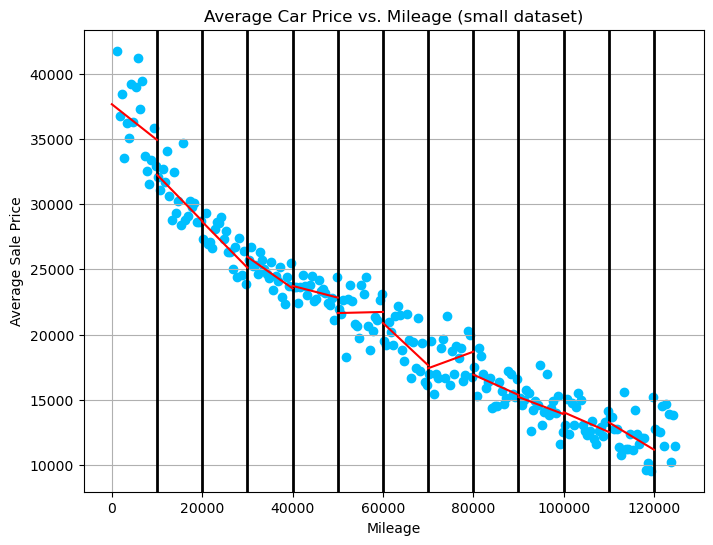

In [ ]:
plot_price_vs_mileage2(False)

# Using the small dataset

## Bagging

In [ ]:
br_results_small = master("BR", False)

## Random forests

In [ ]:
rfr_results_small = master("RFR", False)

## (Extreme Gradient) Boosting

Dataset:  ./etc/training_small.csv


/tmp/ipykernel_47972/1043156605.py:245: DtypeWarning: Columns (11,31) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(dataset)


----------------------------------------------------------------------------------------------------
X_train.tail(2):
          year   mileage  make_name  body_type  combined_fuel_economy  \
6941  0.975309  0.110675          3          6               0.151572   
3512  0.987654  0.075874         15          5               0.080373   

      engine_vol_vs_hp  size_of_vehicle   legroom  
6941          0.688104         1.269426  1.009593  
3512          1.383088         1.858839  0.772461  
----------------------------------------------------------------------------------------------------
Training XGBR...
Starting grid search:  GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
        

/tmp/ipykernel_47972/2380536860.py:103: DtypeWarning: Columns (11,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


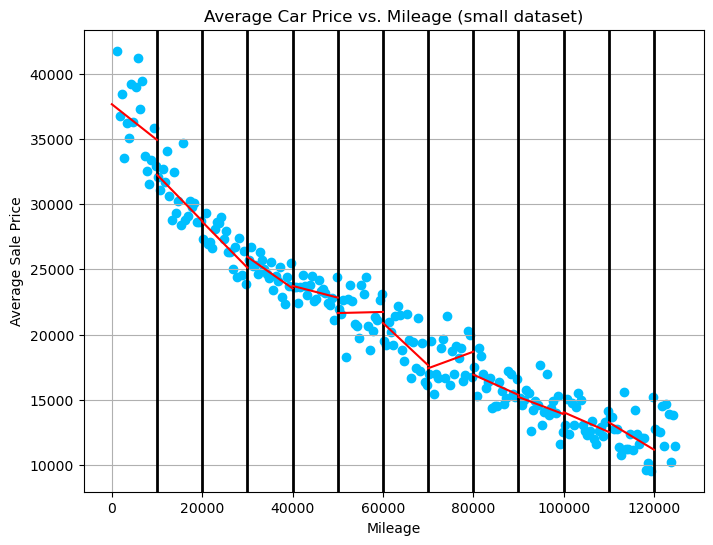

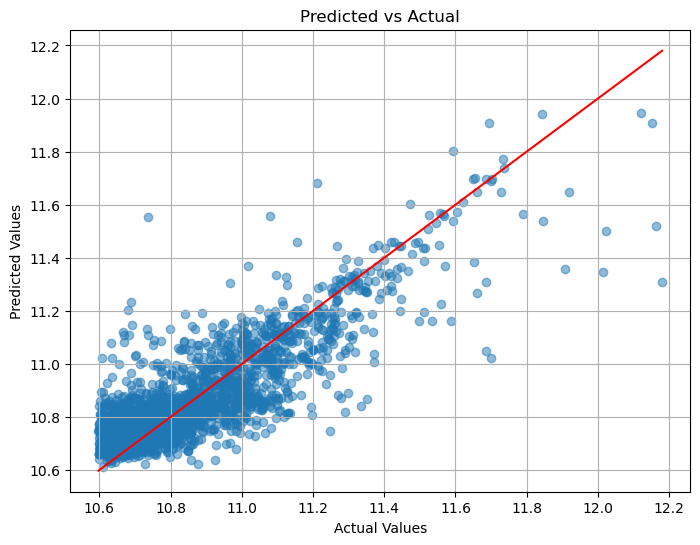

Skew:  0.4502653212327513
Kurtosis:  4.474912147797567


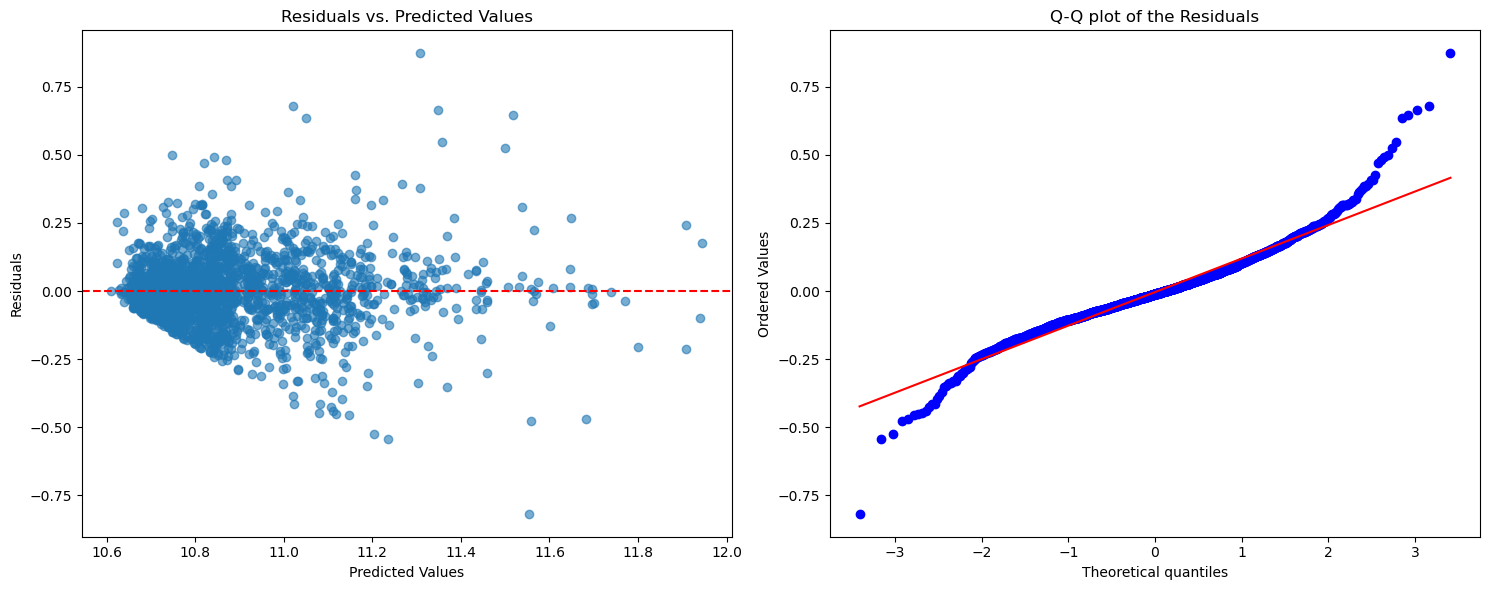

Saving model...
Saved.
----------------------------------------------------------------------------------------------------
Testing...


/tmp/ipykernel_47972/1043156605.py:191: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv(TEST_PATH)


ValueError: Found array with 0 sample(s) (shape=(0, 13)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
xgbr_results_small = master("XGBR", False)

# Using the large dataset

## Bagging

In [ ]:
br_results_large = master("BR", True)

## Random Forests

In [ ]:
rfr_results_large = master("RFR", True)

## (Extreme Gradient) Boosting

Dataset:  ./etc/training_large.csv
------------------------------------
After filtering columns:  Index(['price', 'back_legroom', 'front_legroom', 'fuel_tank_volume', 'height',
       'length', 'wheelbase', 'width', 'maximum_seating', 'city_fuel_economy',
       'highway_fuel_economy', 'engine_type', 'engine_displacement',
       'horsepower', 'year', 'torque', 'mileage', 'make_name', 'body_type'],
      dtype='object')
Before dropping:  Index(['price', 'back_legroom', 'front_legroom', 'fuel_tank_volume', 'height',
       'length', 'wheelbase', 'width', 'maximum_seating', 'city_fuel_economy',
       'highway_fuel_economy', 'engine_type', 'engine_displacement',
       'horsepower', 'year', 'torque', 'mileage', 'make_name', 'body_type',
       'legroom', 'combined_fuel_economy', 'size_of_vehicle',
       'engine_vol_vs_hp', 'torque_value', 'rpm_value'],
      dtype='object')
After dropping:  Index(['maximum_seating', 'engine_type', 'year', 'mileage', 'make_name',
       'body_type', 'leg

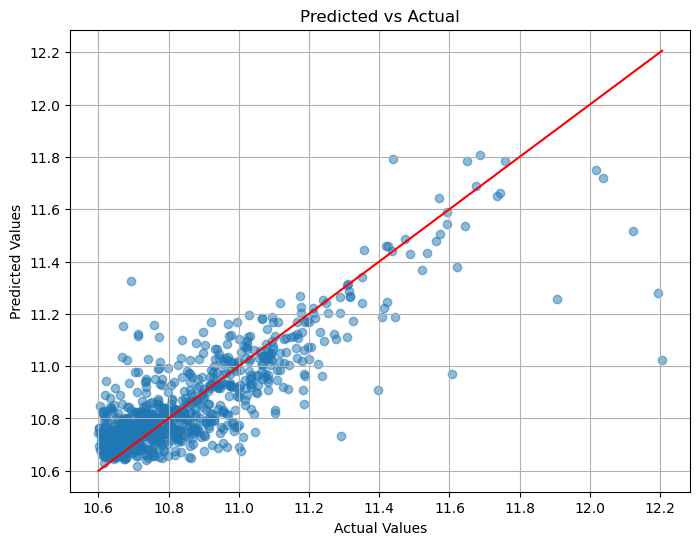

Skew:  1.4720420874890536
Kurtosis:  12.291853563849646


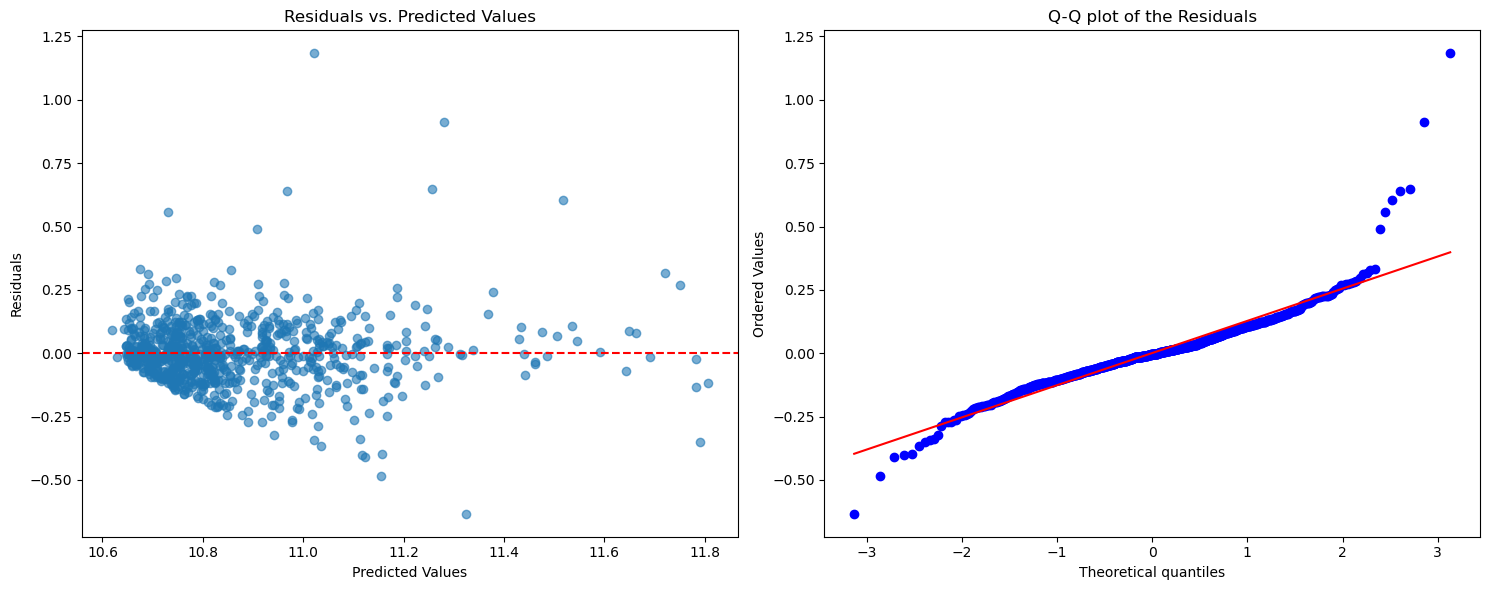

Saving model...
Saved.
------------------------------------
Testing...


/tmp/ipykernel_539023/3809718874.py:271: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv(TEST_PATH)


After filtering columns:  Index(['price', 'back_legroom', 'front_legroom', 'fuel_tank_volume', 'height',
       'length', 'wheelbase', 'width', 'maximum_seating', 'city_fuel_economy',
       'highway_fuel_economy', 'engine_type', 'engine_displacement',
       'horsepower', 'year', 'torque', 'mileage', 'make_name', 'body_type'],
      dtype='object')
Before dropping:  Index(['back_legroom', 'front_legroom', 'fuel_tank_volume', 'height', 'length',
       'wheelbase', 'width', 'maximum_seating', 'city_fuel_economy',
       'highway_fuel_economy', 'engine_type', 'engine_displacement',
       'horsepower', 'year', 'torque', 'mileage', 'make_name', 'body_type',
       'legroom', 'combined_fuel_economy', 'size_of_vehicle',
       'engine_vol_vs_hp', 'torque_value', 'rpm_value'],
      dtype='object')
After dropping:  Index(['maximum_seating', 'engine_type', 'year', 'mileage', 'make_name',
       'body_type', 'legroom', 'combined_fuel_economy', 'size_of_vehicle',
       'engine_vol_vs_hp', 'to

In [ ]:
xgbr_results_large = master("XGBR", True)

In [ ]:
svr_large = master("SVR", True)

In [70]:
df = pd.read_csv(TRAIN_SMALL_PATH)

X, y, les = preprocess(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1203)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 9,
    'subsample': 0.3,
    'colsample_bytree': 0.3,
    'n_jobs': -1
}

# train XGBoost
num_round = 150
model = xgb.train(params, dtrain, num_round)

y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred, squared=False)
r_squared_score = r2_score(y_test, y_pred)
print(f'MSE on validation set: {mse}')
print('R2: ', r_squared_score)

/tmp/ipykernel_47972/2729012442.py:1: DtypeWarning: Columns (11,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TRAIN_SMALL_PATH)


MSE on validation set: 0.13166637050906888
R2:  0.676831081633859


<AxesSubplot:title={'center':'Null count ratio of variable'}>

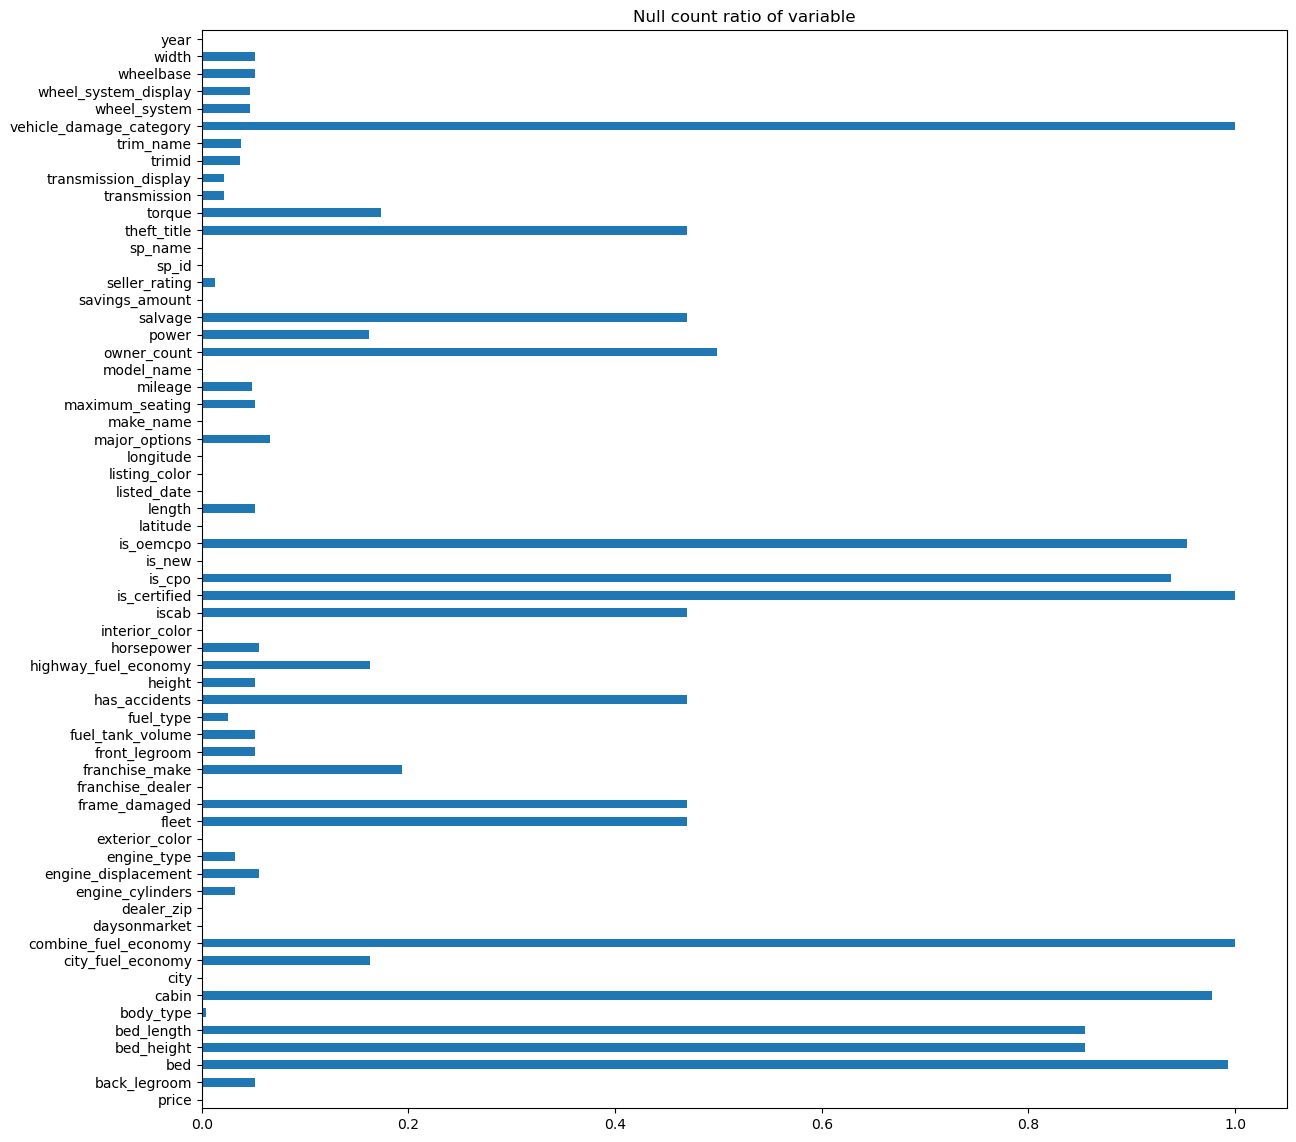

In [76]:
(df.isnull().sum() / len(df)).plot(kind='barh', figsize=(14,14), title='Null count ratio of variable')